In [28]:
from typing import Optional, Callable
import math
import copy
import os

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers.predictive import PredictiveModel
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_sqm_model import TractsModelSqm
from cities.utils.data_loader import select_from_data
from chirho.observational.handlers import condition

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract"],
    "continuous": {
        "housing_units",
        "total_value",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        "segregation_original",
        "white_original",
        'parcel_mean_sqm',
        'parcel_median_sqm',
        'parcel_sqm',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

/var/folders/pq/ntbz4ft13jv662kczkzk32pr0000gn/T/ipykernel_10645/3989056904.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_dataset_read = torch.load(census_tracts_da

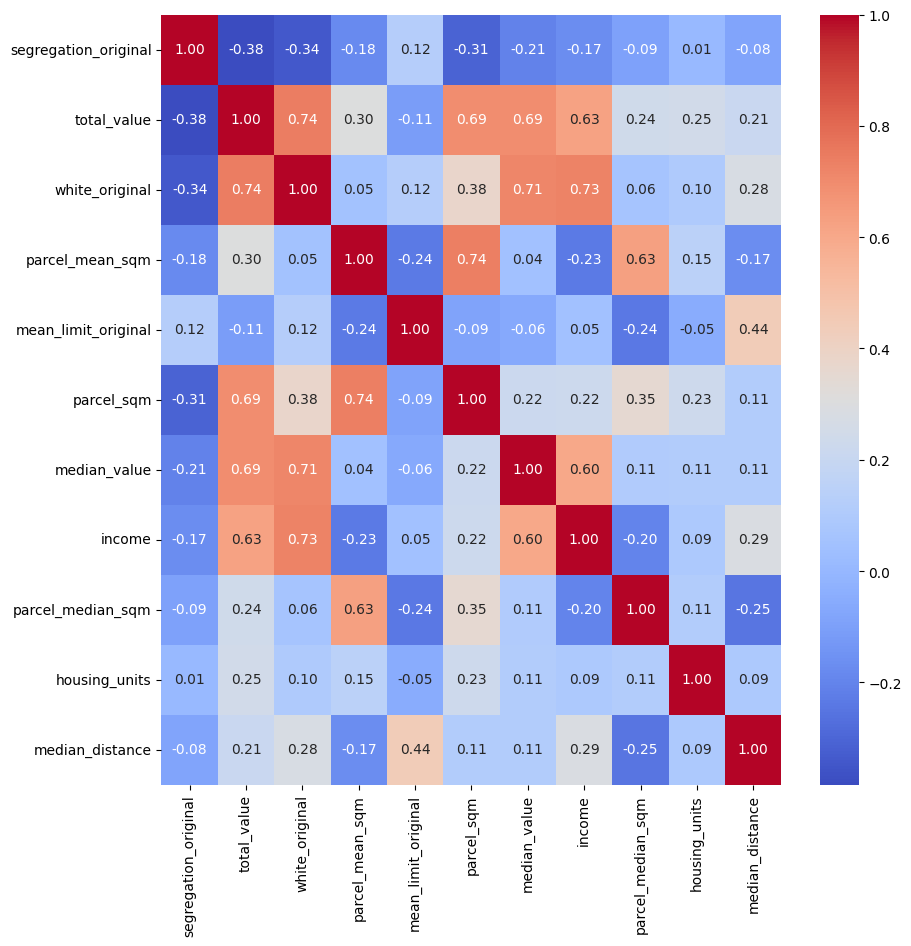

In [3]:
subset['continuous']

subset_continuous = subset['continuous']

continuous_np = {key: tensor.numpy() for key, tensor in subset_continuous.items()}
df = pd.DataFrame(continuous_np)
# columns_to_drop = ['column1', 'column2']
# df = df.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' avoids issues if the columns don't exist

columns = df.columns

vars_to_remove = ["census_tract", "year", "year_id"] + [
    var for var in columns if var.endswith("std")
]

vars = [var for var in columns if var not in vars_to_remove]
# plot spearman correlation between all vars in census[vars]
corr = df[vars].corr(method="spearman")

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


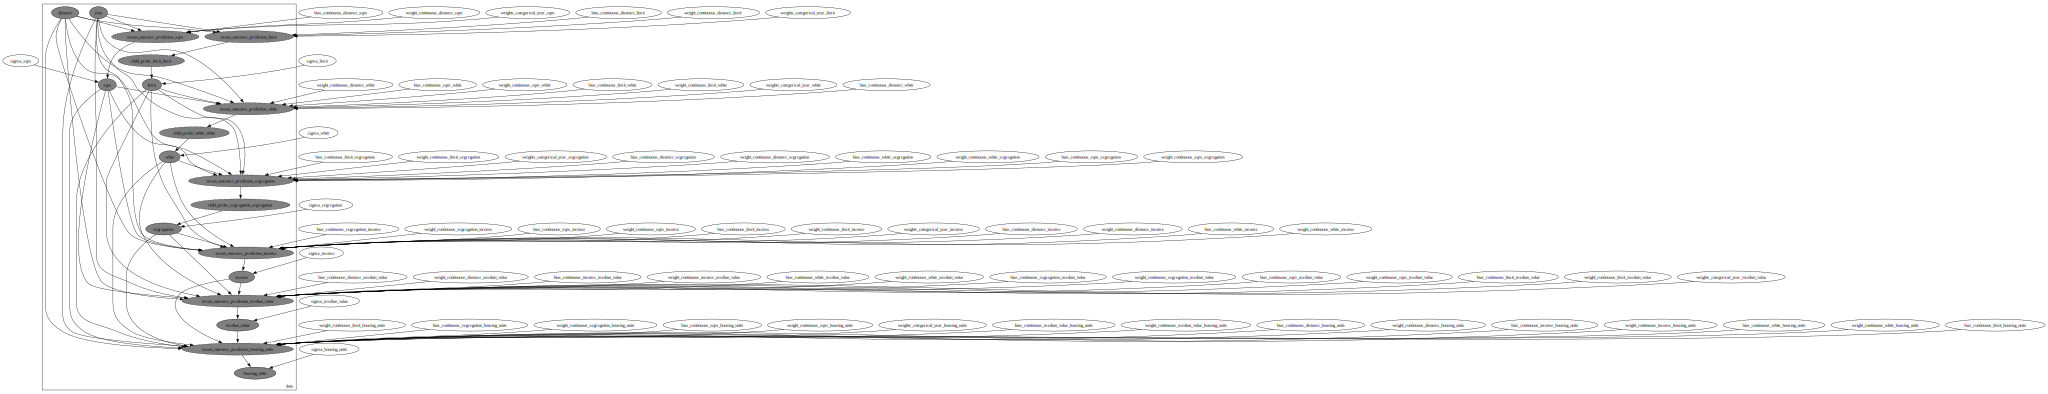

In [4]:
# instantiation and prior predictive run

tracts_model = TractsModelSqm(
    **subset, categorical_levels=ct_dataset_read.categorical_levels
)

with pyro.poutine.trace() as tr:
    tracts_model(**subset)

assert tr.trace.nodes["housing_units"]["value"].shape == torch.Size([1130])

pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True,
)

In [5]:
# pyro.clear_param_store()


# train_loader, test_loader, categorical_levels = prep_data_for_test(
#     census_tracts_data_path, train_size=0.6
# )

# performance_results = test_performance(
#     tracts_model,
#     kwargs,
#     train_loader,
#     test_loader,
#     categorical_levels,
#     outcome_type="continuous",
#     outcome_name="housing_units",
#     n_steps=n_steps,
#     plot=True,
#     is_class=False,
# )

In [13]:
def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


# mae_improvement_train = destandardize_housing_units(
#     performance_results["mae_null_train"] - performance_results["mae_train"]
# )
# mae_improvement_test = destandardize_housing_units(
#     performance_results["mae_null_test"] - performance_results["mae_test"]
# )

# print(
#     f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
# )

[iteration 0001] loss: 301275.5938
[iteration 0050] loss: 31982.9473
[iteration 0100] loss: 15302.8545
[iteration 0150] loss: 11561.7188
[iteration 0200] loss: 10829.0225
[iteration 0250] loss: 10648.9238
[iteration 0300] loss: 10084.6396
[iteration 0350] loss: 9984.5947
[iteration 0400] loss: 9253.4346
[iteration 0450] loss: 9307.4502
[iteration 0500] loss: 9303.7910
[iteration 0550] loss: 9102.7354
[iteration 0600] loss: 9279.9424
[iteration 0650] loss: 9095.4795
[iteration 0700] loss: 9109.2686
[iteration 0750] loss: 9095.9639
[iteration 0800] loss: 9111.4922
[iteration 0850] loss: 9056.3086
[iteration 0900] loss: 8985.9668
[iteration 0950] loss: 9064.6963
[iteration 1000] loss: 8996.1299
[iteration 1050] loss: 8993.6650
[iteration 1100] loss: 9009.5840
[iteration 1150] loss: 8991.8115
[iteration 1200] loss: 9032.8604
[iteration 1250] loss: 9005.8105
[iteration 1300] loss: 9060.6758
[iteration 1350] loss: 8901.3076
[iteration 1400] loss: 8916.2988
[iteration 1450] loss: 8944.9629
[i

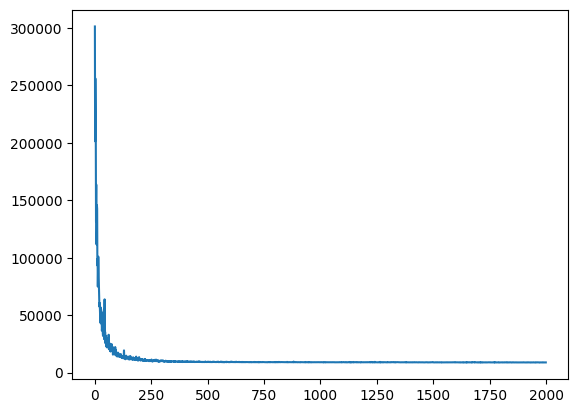

In [7]:
pyro.clear_param_store()
guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset)

predictive = Predictive(tracts_model, guide=guide, num_samples=num_samples)


In [8]:
if not smoke_test:
    serialized_guide = dill.dumps(guide)
    file_path = os.path.join(root, "data/minneapolis/guides", f"tracts_sqm_model_guide_pg.pkl")
    with open(file_path, "wb") as file:
        file.write(serialized_guide)

    param_path = os.path.join(
        root, "data/minneapolis/guides", "tracts_sqm_model_params_pg.pth"
    )

    pyro.get_param_store().save(param_path)

In [9]:

subset_for_preds = copy.deepcopy(subset)
vars_to_suspend = ["housing_units"] #, "white", "segregation", "income", "median_value"]

for var in vars_to_suspend:
    subset_for_preds["continuous"][var] = None


preds = predictive(**subset_for_preds)

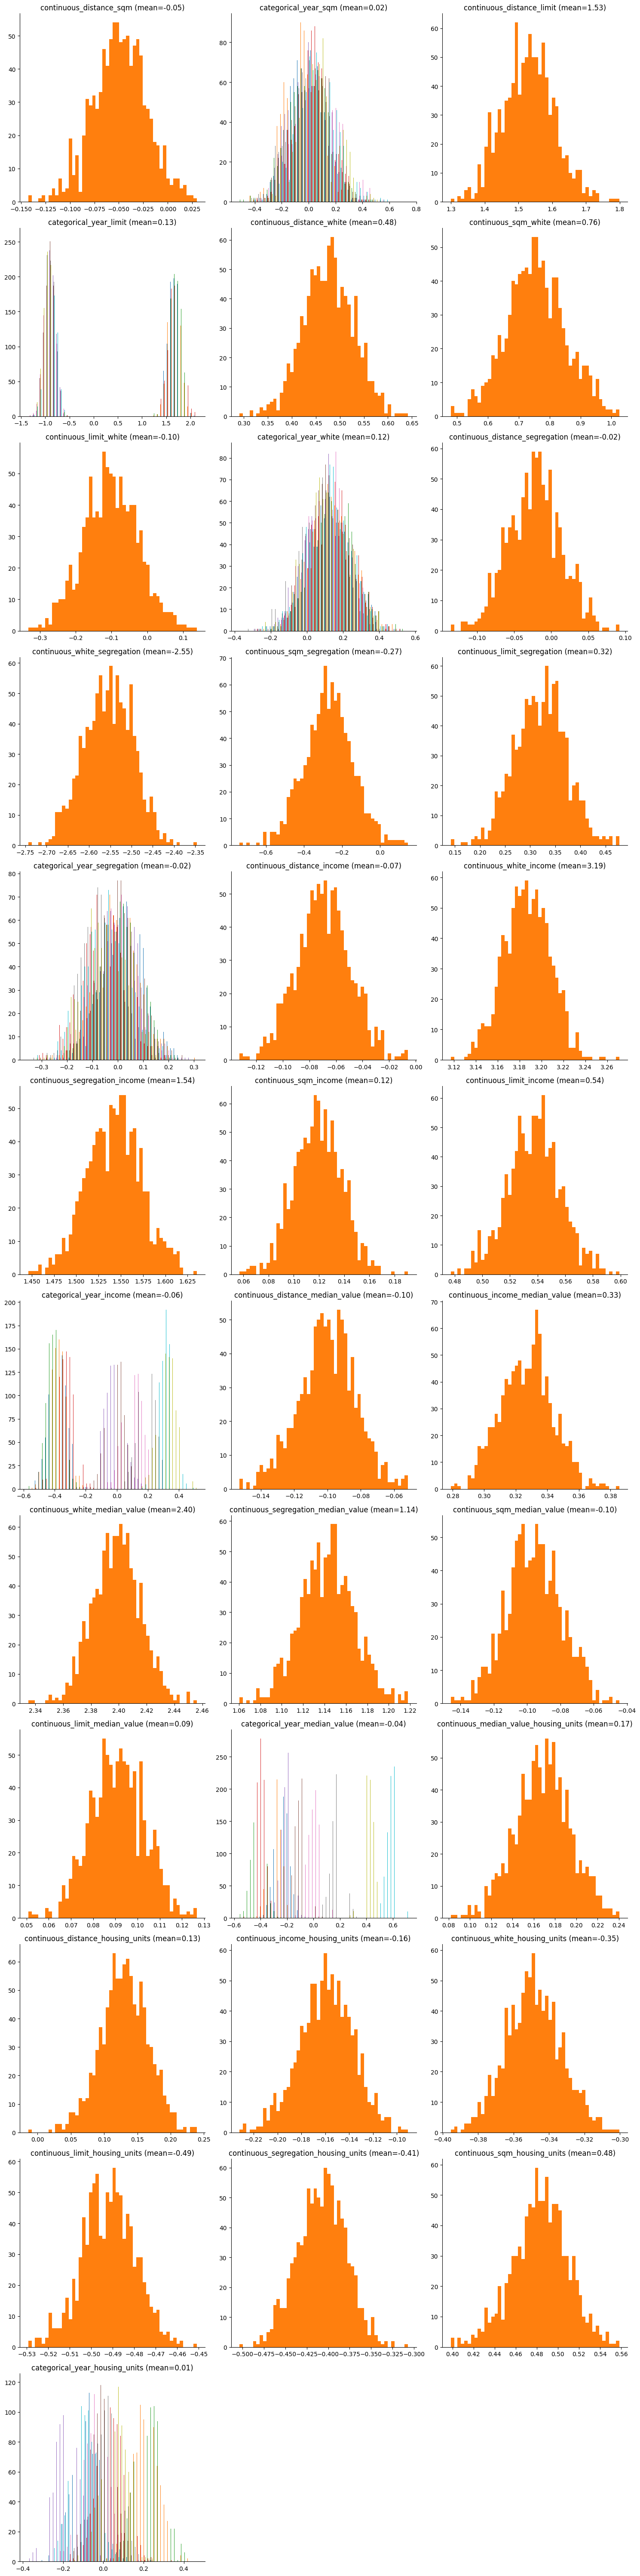

In [10]:
weight_keys = [key for key in preds.keys() if key.startswith("weight")]

n_keys = len(weight_keys)
n_cols = 3
n_rows = (n_keys + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()

for i, key in enumerate(weight_keys):
    mean_val = preds[key].mean().item()
    axs[i].hist(preds[key].squeeze().detach().numpy(), bins=50)
    key_title = key.replace("weights_", "").replace("weight_", "")
    axs[i].hist(preds[key].squeeze().detach().numpy(), bins=50)
    axs[i].set_title(f"{key_title} (mean={mean_val:.2f})")


for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

sns.despine()
plt.tight_layout()
plt.show()

torch.Size([1000, 3, 1, 1, 1, 1130])
torch.Size([1000, 3, 1, 1, 1, 1130])
tensor(0.0324) tensor(0.3798) tensor(-0.1146)


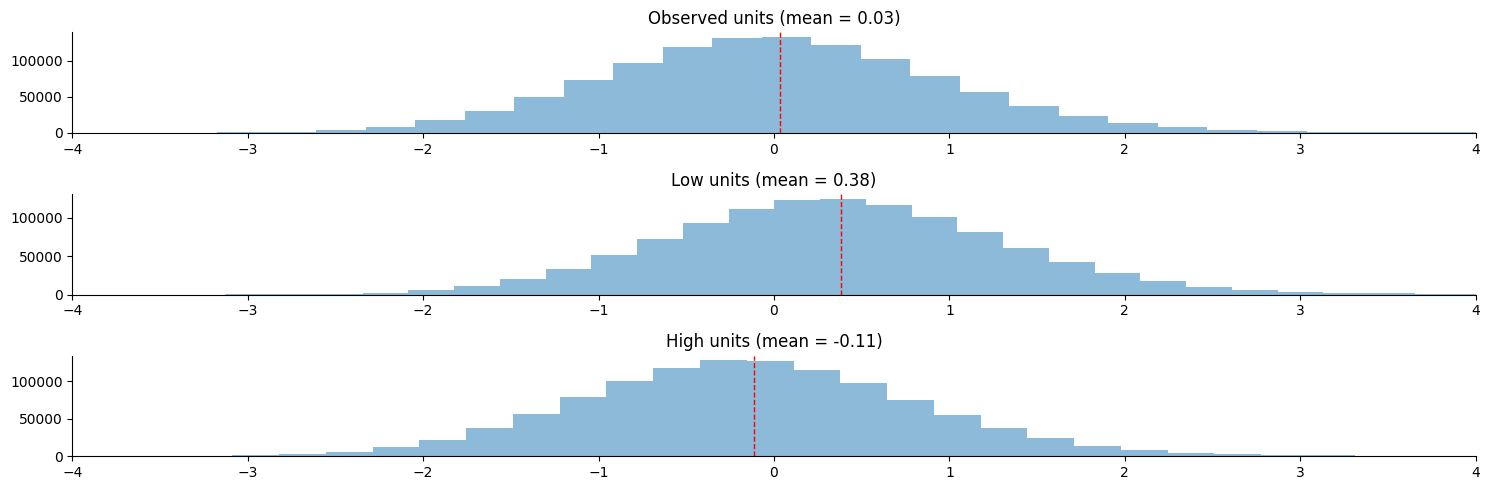

In [11]:
predictive = Predictive(tracts_model, guide=guide, num_samples=num_samples)

with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit": (torch.tensor(0.0), torch.tensor(1.0))}):
        samples = predictive(**subset_for_preds)

print(samples["limit"].shape)
print(samples["housing_units"].shape)

value = samples["limit"]
outcome = samples["housing_units"]

with mwc:
    observed_limit = gather(value, IndexSet(**{"limit": {0}}), event_dims=0)
    low_limit = gather(value, IndexSet(**{"limit": {1}}), event_dims=0)
    high_limit = gather(value, IndexSet(**{"limit": {2}}), event_dims=0)

    observed_units = gather(outcome, IndexSet(**{"limit": {0}}), event_dims=0)
    low_units = gather(outcome, IndexSet(**{"limit": {1}}), event_dims=0)
    high_units = gather(outcome, IndexSet(**{"limit": {2}}), event_dims=0)


fig, axes = plt.subplots(3, 1, figsize=(15, 5))


observed_mean = observed_units.mean()
low_mean = low_units.mean()
high_mean = high_units.mean()

print(observed_mean, low_mean, high_mean)

axes[0].hist(
    observed_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="observed"
)
axes[0].axvline(observed_mean, color="r", linestyle="dashed", linewidth=1)
axes[0].set_title(f"Observed units (mean = {observed_mean:.2f})")
axes[0].set_xlim(-4, 4)

axes[1].hist(low_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="low")
axes[1].axvline(low_mean, color="r", linestyle="dashed", linewidth=1)
axes[1].set_title(f"Low units (mean = {low_mean:.2f})")
axes[1].set_xlim(-4, 4)

axes[2].hist(high_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="high")
axes[2].axvline(high_mean, color="r", linestyle="dashed", linewidth=1)
axes[2].set_title(f"High units (mean = {high_mean:.2f})")
axes[2].set_xlim(-4, 4)

plt.tight_layout()
sns.despine()
plt.show()

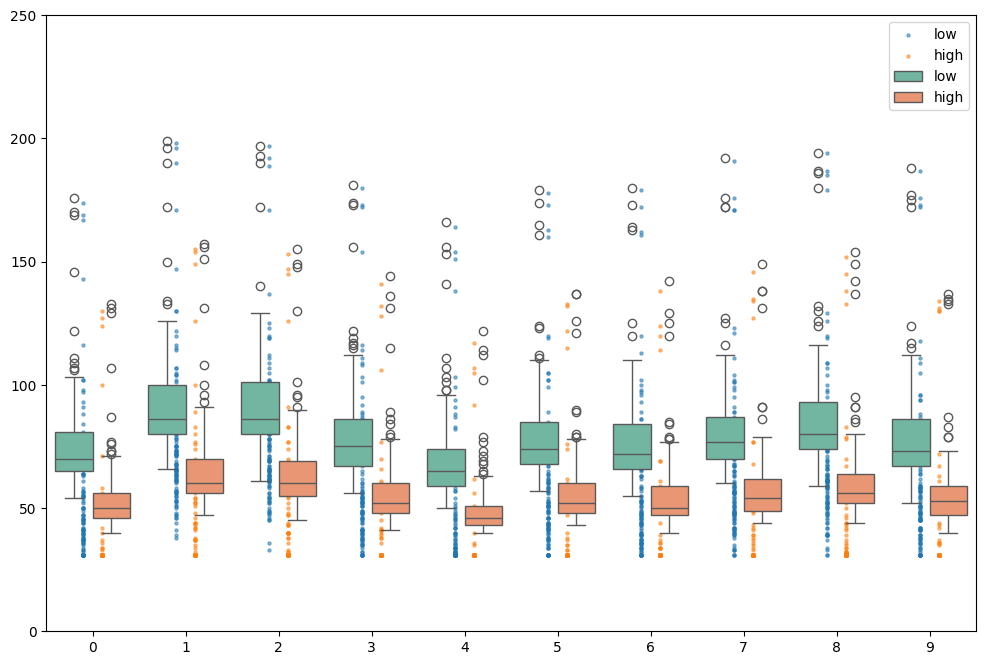

In [14]:
years = data["categorical"]["year"].flatten().detach().numpy()
years_full = years - 0.1
years_no = years + 0.1


plt.figure(figsize=(12, 8))
plt.scatter(
    x=years_full,
    y=destandardize_housing_units(low_units.mean(axis=0).clamp(min=0).flatten().detach()),
    s=5,
    alpha=0.5,
    label="low",
)


plt.scatter(
    x=years_no,
    y=destandardize_housing_units(high_units.mean(axis=0).clamp(min =0).flatten().detach()),
    s=5,
    alpha=0.5,
    label="high",
)


data_combined = np.concatenate(
    (
        destandardize_housing_units(low_units.clamp(min = 0).mean(axis=0).flatten()),
        destandardize_housing_units(high_units.clamp(min=0).mean(axis=0).flatten()),
    )
)
years_combined = np.concatenate((years, years))
labels_combined = np.concatenate(
    (np.repeat("low", len(years)), np.repeat("high", len(years)))
)


boxplot = sns.boxplot(
    x=years_combined,
    y=data_combined,
    hue=labels_combined,
    dodge=True,
    palette="Set2",
   
)

plt.ylim(0,250)
plt.legend()
plt.show()

Explainability questions:

In [15]:
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports

In [16]:
learned_model = PredictiveModel(tracts_model, guide=guide)
with ExtractSupports() as s:
    learned_model(**subset)

print(s.supports)

{'_AutoMultivariateNormal_latent': IndependentConstraint(Real(), 1), 'sigma_sqm': IndependentConstraint(Real(), 0), 'bias_continuous_distance_sqm': IndependentConstraint(Real(), 0), 'weight_continuous_distance_sqm': IndependentConstraint(Real(), 0), 'weights_categorical_year_sqm': IndependentConstraint(Real(), 1), 'bias_continuous_distance_limit': IndependentConstraint(Real(), 0), 'weight_continuous_distance_limit': IndependentConstraint(Real(), 0), 'weights_categorical_year_limit': IndependentConstraint(Real(), 1), 'sigma_limit': IndependentConstraint(Real(), 0), 'bias_continuous_distance_white': IndependentConstraint(Real(), 0), 'weight_continuous_distance_white': IndependentConstraint(Real(), 0), 'bias_continuous_sqm_white': IndependentConstraint(Real(), 0), 'weight_continuous_sqm_white': IndependentConstraint(Real(), 0), 'bias_continuous_limit_white': IndependentConstraint(Real(), 0), 'weight_continuous_limit_white': IndependentConstraint(Real(), 0), 'weights_categorical_year_white

In [79]:
query = SearchForExplanation(
    supports=s.supports,
    antecedents={"limit": torch.tensor(1.0), "median_value": torch.tensor(1.0)},
    consequents={"housing_units": torch.tensor(0.01)},
    witnesses={}, # potential context elements, we leave them empty for now
    # alternatives={"limit": torch.tensor(0.0)},
    consequent_scale=1e-5,
)(learned_model)

In [80]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = 9  # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual() as mwc:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

        return torch.logsumexp(log_weights, dim=0) - math.log(num_samples), importance_tr, mwc, log_weights

    return _wrapped_model

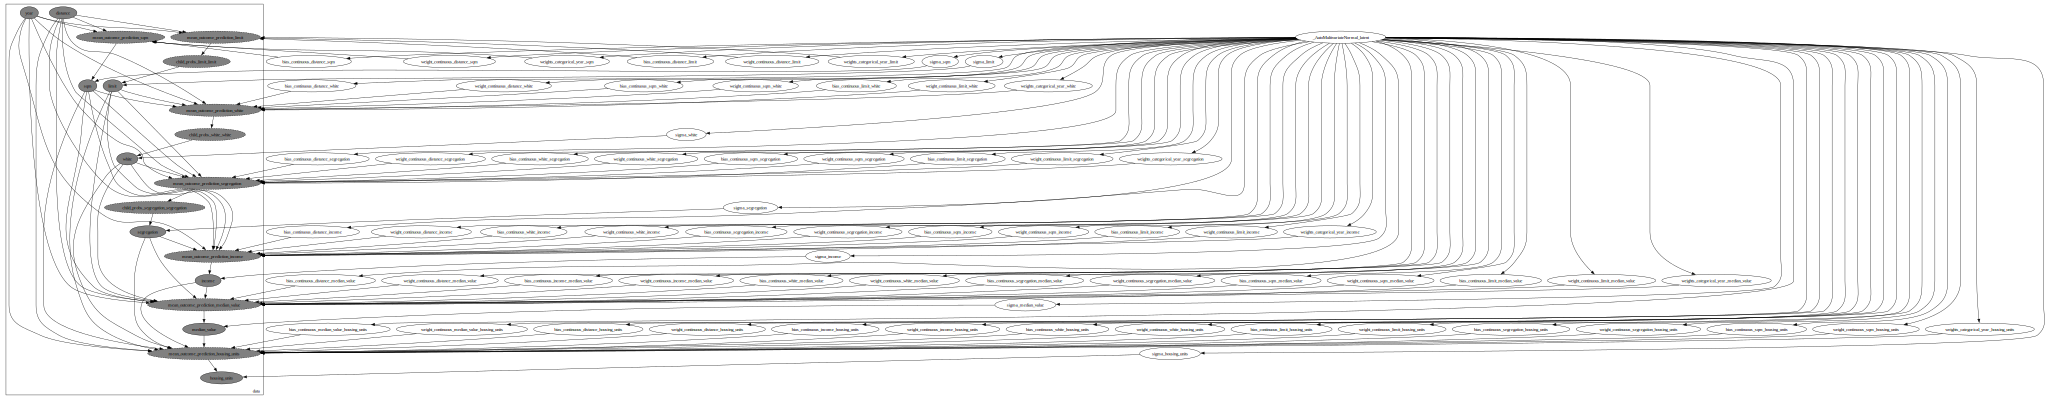

In [81]:
pyro.render_model(
    lambda: learned_model(**subset),
    render_deterministic=True,
)

In [82]:
logp, trace, mwc, log_weights = importance_infer(num_samples=10)(query)(**subset)

RuntimeError: shape mismatch: value tensor of shape [10, 1, 1, 1, 1, 1, 1, 1, 1, 1130] cannot be broadcast to indexing result of shape [1, 1, 1, 1, 1130]
                                    Trace Shapes:                                
                                     Param Sites:                                
                     AutoMultivariateNormal.scale                         131    
                AutoMultivariateNormal.scale_tril                     131 131    
                       AutoMultivariateNormal.loc                         131    
                                    Sample Sites:                                
                    num_particles_vectorized dist                           |    
                                            value                      10   |    
              _AutoMultivariateNormal_latent dist 10 1 1 1 1 1 1 1 1    1   | 131
                                            value 10 1 1 1 1 1 1 1 1    1   | 131
                                   sigma_sqm dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                bias_continuous_distance_sqm dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
              weight_continuous_distance_sqm dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                weights_categorical_year_sqm dist 10 1 1 1 1 1 1 1 1    1   |  10
                                            value 10 1 1 1 1 1 1 1 1    1   |  10
              bias_continuous_distance_limit dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
            weight_continuous_distance_limit dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
              weights_categorical_year_limit dist 10 1 1 1 1 1 1 1 1    1   |  10
                                            value 10 1 1 1 1 1 1 1 1    1   |  10
                                 sigma_limit dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
              bias_continuous_distance_white dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
            weight_continuous_distance_white dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                   bias_continuous_sqm_white dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                 weight_continuous_sqm_white dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                 bias_continuous_limit_white dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
               weight_continuous_limit_white dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
              weights_categorical_year_white dist 10 1 1 1 1 1 1 1 1    1   |  10
                                            value 10 1 1 1 1 1 1 1 1    1   |  10
                                 sigma_white dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
        bias_continuous_distance_segregation dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
      weight_continuous_distance_segregation dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
           bias_continuous_white_segregation dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
         weight_continuous_white_segregation dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
             bias_continuous_sqm_segregation dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
           weight_continuous_sqm_segregation dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
           bias_continuous_limit_segregation dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
         weight_continuous_limit_segregation dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
        weights_categorical_year_segregation dist 10 1 1 1 1 1 1 1 1    1   |  10
                                            value 10 1 1 1 1 1 1 1 1    1   |  10
                           sigma_segregation dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                                sigma_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
             bias_continuous_distance_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
           weight_continuous_distance_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                bias_continuous_white_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
              weight_continuous_white_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
          bias_continuous_segregation_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
        weight_continuous_segregation_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                  bias_continuous_sqm_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                weight_continuous_sqm_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
                bias_continuous_limit_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
              weight_continuous_limit_income dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
             weights_categorical_year_income dist 10 1 1 1 1 1 1 1 1    1   |  10
                                            value 10 1 1 1 1 1 1 1 1    1   |  10
                          sigma_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
       bias_continuous_distance_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
     weight_continuous_distance_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
         bias_continuous_income_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
       weight_continuous_income_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
          bias_continuous_white_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
        weight_continuous_white_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
    bias_continuous_segregation_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
  weight_continuous_segregation_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
            bias_continuous_sqm_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
          weight_continuous_sqm_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
          bias_continuous_limit_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
        weight_continuous_limit_median_value dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
       weights_categorical_year_median_value dist 10 1 1 1 1 1 1 1 1    1   |  10
                                            value 10 1 1 1 1 1 1 1 1    1   |  10
                         sigma_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
  bias_continuous_median_value_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
weight_continuous_median_value_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
      bias_continuous_distance_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
    weight_continuous_distance_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
        bias_continuous_income_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
      weight_continuous_income_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
         bias_continuous_white_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
       weight_continuous_white_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
         bias_continuous_limit_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
       weight_continuous_limit_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
   bias_continuous_segregation_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
 weight_continuous_segregation_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
           bias_continuous_sqm_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
         weight_continuous_sqm_housing_units dist 10 1 1 1 1 1 1 1 1    1   |    
                                            value 10 1 1 1 1 1 1 1 1    1   |    
      weights_categorical_year_housing_units dist 10 1 1 1 1 1 1 1 1    1   |  10
                                            value 10 1 1 1 1 1 1 1 1    1   |  10
                                        data dist                           |    
                                            value                    1130   |    
                 __cause___alternative_limit dist 10 1 1 1 1 1 1 1 1 1130   |    
                                            value 10 1 1 1 1 1 1 1 1 1130   |    

In [ ]:
import torch
from copy import deepcopy
from cities.modeling.model_components import get_n

def nonify_dict_(d):
    for k, v in d.items():
        if isinstance(v, torch.Tensor):
            d[k] = None
        elif isinstance(v, dict):
            d[k] = nonify_dict_(v)
    return d


def nonify_dict(d):
    d = deepcopy(d)
    return nonify_dict_(d)


SUBSET_SITE_NAME_MAP = {
    "white": "white_original",
    "segregation": "segregation_original",
    "limit": "mean_limit_original",
    "distance": "median_distance",
}


def map_subset_onto_obs(subset, site_names):
    obs = dict()

    for name in site_names:
        subset_name = SUBSET_SITE_NAME_MAP.get(name, name)
        for k, inner_subset_dict in subset.items():
            if k == "outcome":
                continue
            if subset_name in inner_subset_dict:
                obs[name] = inner_subset_dict[subset_name]
                break

    assert obs.keys() == set(site_names), f"Missing keys: {set(site_names) - obs.keys()}"
    return obs

In [83]:
levels = get_n(subset_for_preds['categorical'], subset_for_preds['continuous'])
a = nonify_dict(subset_for_preds)
a, levels

({'outcome': None,
  'categorical': {'year': None, 'census_tract': None},
  'continuous': {'segregation_original': None,
   'total_value': None,
   'white_original': None,
   'parcel_mean_sqm': None,
   'mean_limit_original': None,
   'parcel_sqm': None,
   'median_value': None,
   'income': None,
   'parcel_median_sqm': None,
   'housing_units': None,
   'median_distance': None}},
 (2, 11, 1130))

In [85]:
with MultiWorldCounterfactual() as mwc:
    with SearchForExplanation(
        supports=s.supports,
        antecedents={"limit": torch.tensor(1.0)},
        consequents={"housing_units": torch.tensor(0.3)},
        witnesses={}, # potential context elements, we leave them empty for now
        # alternatives={"limit": torch.tensor(0.0)},
        antecedent_bias=-0.5,
        consequent_scale=1e-5,
    ):
        with pyro.poutine.trace() as tr_conditioned:
            with pyro.plate("samples", size=1, dim=-2):
                learned_model(**a, levels = levels)

__cause____antecedent_limit


In [86]:
from chirho.indexed.ops import indices_of
for i in tr_conditioned.trace.nodes.keys():
    if i.startswith('__cause__'):
        print(i)
probs = tr_conditioned.trace.compute_log_prob()

print(probs)

print(len(subset_for_preds['categorical']['year']))

# print(tr_conditioned.trace.nodes['__cause____antecedent_limit'])


# with mwc:
#     print(gather(tr_conditioned.trace.nodes['year']['value'], IndexSet(**{"limit": {0}})))
#     print(gather(tr_conditioned.trace.nodes['income']['value'], IndexSet(**{"limit": {0}}))[:, :, :, :, 0])
#     print(gather(tr_conditioned.trace.nodes['income']['value'], IndexSet(**{"limit": {1}})))
#     print(gather(tr_conditioned.trace.nodes['income']['value'], IndexSet(**{"limit": {2}})))
    

log_probs = tr_conditioned.trace.nodes['__cause____consequent_housing_units']['log_prob'].sum(dim=0)
Z = torch.logsumexp(log_probs.flatten(), dim=-1)
probs = torch.exp(log_probs - Z)


__cause____antecedent_limit
__cause____consequent_housing_units
None
1130


In [87]:
probs[probs > 0]

tensor([1.], grad_fn=<IndexBackward0>)